In [ ]:
from Patient import Patient
from Room import Room
import pandas as pd
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import time

######## READ DATA ###########
Patient_data = pd.read_csv('Patient100.csv')
Rooms_data = pd.read_csv('Rooms.csv')

######## Variables ##########

# random.seed(10)

def init_rooms(Rooms_data):
    room_dict = {}
    for room in Rooms_data.iterrows():
        room_dict[room[1]['id']] = Room(room[1]['id'],room[1]['x'],room[1]['y'])
    return room_dict


def init_patient(Patient_data,r_data):
    patient_array = []
    for patient in Patient_data.iterrows():
        patient_array.append(Patient(patient[1]['id'],r_data[patient[1]['room']],patient[1]['urgency'], patient[1]['typeofdisease']))
    return patient_array

def calc_dist(room1 , room2):
    return(math.sqrt(((room1[0] - room2[0])**2) + ((room1[1] - room2[1])**2)))



def room_distance_matrix(room_data):
    df = pd.DataFrame(columns=range(1,len(room_data)+1), index=range(1,len(room_data)+1))
    for i in room_data.keys():
        for j in room_data.keys():
            df.at[i,j] = calc_dist(room_data[i].get_loc(),room_data[j].get_loc())
    return df

def patient_distance_matrix(patient_data):
    df = pd.DataFrame(columns=range(1,len(patient_data)+1), index=range(1,len(patient_data)+1))
    for i in range(1,len(patient_data)+1):
        for j in range(1,len(patient_data)+1):
            df.at[i,j] = calc_dist(patient_data[i-1].room.get_loc(), patient_data[j-1].room.get_loc())
    return df


################# for plot ###########################
# def plotonimage(room_data):
#     x_arr = []
#     y_arr = []
#     for room in room_data.values():
#         temp_room_loc = room.get_loc()
#         x_arr.append(temp_room_loc[0])
#         y_arr.append(temp_room_loc[1])
#
#     plt.plot(x_arr , y_arr, linestyle = 'dashed', marker='s')
#
#     # plt.scatter(x_arr,y_arr)
#     plt.show()

################# for plot ###########################




def randomSolution(tsp):
    patients = list(range(len(tsp)))
    solution = []

    for i in range(len(tsp)):
        random_patient = patients[random.randint(0, len(patients) - 1)]
        solution.append(random_patient)
        patients.remove(random_patient)

    return solution

def objective_function(tsp, solution, patients, robot_speed,cost):
    target_value = 0
    time_of = 0
    for i in range(len(solution)):
        time_of += (tsp[solution[i - 1]][solution[i]] / robot_speed) + patients[solution[i-1]].type_of_disease
        latency = max((time_of - patients[solution[i-1]].urgency), 0)
        target_value = (time_of + latency * cost)
    return target_value

def getNeighbours(solution):
    neighbours = []
    for i in range(len(solution)):
        for j in range(i + 1, len(solution)):
            neighbour = solution.copy()
            neighbour[i] = solution[j]
            neighbour[j] = solution[i]
            neighbours.append(neighbour)
    return neighbours

def getBestNeighbour(tsp, neighbours, patients, robot_speed,cost):
    bestRouteLength = objective_function(tsp, neighbours[0], patients, robot_speed, cost)
    bestNeighbour = neighbours[0]
    for neighbour in neighbours:
        currentRouteLength = objective_function(tsp, neighbour, patients, robot_speed, cost)
        if currentRouteLength < bestRouteLength:
            bestRouteLength = currentRouteLength
            bestNeighbour = neighbour
    return bestNeighbour, bestRouteLength

def hillClimbing(tsp, patients, robot_speed, cost, max_time, time_limit):
    currentSolution = randomSolution(tsp)
    currentRouteLength = objective_function(tsp, currentSolution, patients, robot_speed, cost)
    neighbours = getNeighbours(currentSolution)
    bestNeighbour, bestNeighbourRouteLength = getBestNeighbour(tsp, neighbours,patients, robot_speed, cost)
    start_time = time.time()
    if time_limit:
        while not isDone(start_time, max_time):  ## checks if the algorithm has more time to run
            neighbours = getNeighbours(currentSolution)
            bestNeighbour, bestNeighbourRouteLength = getBestNeighbour(tsp, neighbours, patients, robot_speed, cost)
            if bestNeighbourRouteLength < currentRouteLength:
                currentRouteLength = bestNeighbourRouteLength
                currentSolution = bestNeighbour
    else:
        while bestNeighbourRouteLength < currentRouteLength:
            currentSolution = bestNeighbour
            currentRouteLength = bestNeighbourRouteLength
            neighbours = getNeighbours(currentSolution)
            bestNeighbour, bestNeighbourRouteLength = getBestNeighbour(tsp, neighbours, patients, robot_speed, cost)
    return currentSolution, currentRouteLength

def isDone(start_time, max_time):
    return time.time() - start_time > max_time

def hill_climb_algorithm(matrix, patients, robot_speed, cost, max_time, time_limit):
    tsp = matrix.values.tolist()
    return(hillClimbing(tsp, patients, robot_speed, cost, max_time, time_limit))

def patient_to_room_arr(pat_arr,patient_data):
    room_arr = []
    x_arr = []
    y_arr =[]
    # room_arr.append(patient_data[pat_arr[0]].room.get_loc())
    for patient in pat_arr:
        room_arr.append(patient_data[patient].room.get_loc())
    # print(room_arr)
    for cord in room_arr:
        x_arr.append(cord[0])
        y_arr.append(cord[1])
    fig, ax = plt.subplots()
    u = np.diff(x_arr)
    v = np.diff(y_arr)
    u = np.array([2 if x == 0 else x for x in u])
    v = np.array([2 if x == 0 else x for x in v])
    pos_x = x_arr[:-1] + u / 2
    pos_y = y_arr[:-1] + v / 2
    norm = np.sqrt(abs(u * 2 + v * 2))
    ax.plot(x_arr[:-1], y_arr[:-1], marker="o")
    # ax.quiver(pos_x, pos_y, u / norm, v / norm, angles="xy", zorder=5, pivot='mid')
    plt.title("Path to Rooms")
    plt.show()
    for i in range(0,len(x_arr)-1):
        j = i
        if j >= (len(x_arr)-1):
            break
        while x_arr[i] == x_arr[j+1] and y_arr[i] == y_arr[j+1]:
            x_arr[j + 1] = x_arr[j + 1] + 3
            y_arr[j + 1] = y_arr[j + 1] + 3
            if (j+1) < (len(x_arr) - 1):
                j = j + 1
            else:
                break
    fig, ax = plt.subplots()
    u = np.diff(x_arr)
    v = np.diff(y_arr)
    u = np.array([2 if x == 0 else x for x in u])
    v = np.array([2 if x == 0 else x for x in v])
    pos_x = x_arr[:-1] + u / 2
    pos_y = y_arr[:-1] + v / 2
    norm = np.sqrt(abs(u * 2 + v * 2))
    ax.plot(x_arr[:-1], y_arr[:-1], marker="o")
    # ax.quiver(pos_x, pos_y, u / norm, v / norm, angles="xy", zorder=5, pivot='mid')
    plt.title("Path to Patients")
    plt.show()

if __name__ == '__main__':
    start_time = time.time()
    room_data = init_rooms(Rooms_data)
    patient_data = init_patient(Patient_data, room_data)
    rooms_dist_matrix = room_distance_matrix(room_data)
    patients_dist_matrix = patient_distance_matrix(patient_data)
    robot_speed= 6
    cost = 200
    time_limit = False
    max_time = 10
    # plotonimage(room_data)
    # for robot_speed in range(2,10):
    for cost in range(0,501,50):
#     for max_time in range(5,9,5):
        hill_climb_result = hill_climb_algorithm(patients_dist_matrix, patient_data, robot_speed, cost, max_time, time_limit)
        print(hill_climb_result)

    patient_to_room_arr(hill_climb_result[0],patient_data)
    print(time.time() - start_time)

In [ ]:
from Patient import Patient
from Room import Room
import pandas as pd
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import time

######## READ DATA ###########
Patient_data = pd.read_csv('Patient10.csv')
Rooms_data = pd.read_csv('Rooms.csv')


######## Variables ##########

# random.seed(10)

def init_rooms(Rooms_data):
    room_dict = {}
    for room in Rooms_data.iterrows():
        room_dict[room[1]['id']] = Room(room[1]['id'], room[1]['x'], room[1]['y'])
    return room_dict


def init_patient(Patient_data, r_data):
    patient_array = []
    for patient in Patient_data.iterrows():
        patient_array.append(
            Patient(patient[1]['id'], r_data[patient[1]['room']], patient[1]['urgency'], patient[1]['typeofdisease']))
    return patient_array


def calc_dist(room1, room2):
    return (math.sqrt(((room1[0] - room2[0]) ** 2) + ((room1[1] - room2[1]) ** 2)))


def room_distance_matrix(room_data):
    df = pd.DataFrame(columns=range(1, len(room_data) + 1), index=range(1, len(room_data) + 1))
    for i in room_data.keys():
        for j in room_data.keys():
            df.at[i, j] = calc_dist(room_data[i].get_loc(), room_data[j].get_loc())
    return df


def patient_distance_matrix(patient_data):
    df = pd.DataFrame(columns=range(1, len(patient_data) + 1), index=range(1, len(patient_data) + 1))
    for i in range(1, len(patient_data) + 1):
        for j in range(1, len(patient_data) + 1):
            df.at[i, j] = calc_dist(patient_data[i - 1].room.get_loc(), patient_data[j - 1].room.get_loc())
    return df


################# for plot ###########################
# def plotonimage(room_data):
#     x_arr = []
#     y_arr = []
#     for room in room_data.values():
#         temp_room_loc = room.get_loc()
#         x_arr.append(temp_room_loc[0])
#         y_arr.append(temp_room_loc[1])
#
#     plt.plot(x_arr , y_arr, linestyle = 'dashed', marker='s')
#
#     # plt.scatter(x_arr,y_arr)
#     plt.show()

################# for plot ###########################


def randomSolution(tsp):
    patients = list(range(len(tsp)))
    solution = []

    for i in range(len(tsp)):
        random_patient = patients[random.randint(0, len(patients) - 1)]
        solution.append(random_patient)
        patients.remove(random_patient)

    return solution


def objective_function(tsp, solution, patients, robot_speed, cost):
    target_value = 0
    time_of = 0
    for i in range(len(solution)):
        time_of += (tsp[solution[i - 1]][solution[i]] / robot_speed) + patients[solution[i - 1]].type_of_disease
        latency = max((time_of - patients[solution[i - 1]].urgency), 0)
        target_value = (time_of + latency * cost)
    return target_value


def getNeighbours(solution):
    neighbours = []
    for i in range(len(solution)):
        for j in range(i + 1, len(solution)):
            neighbour = solution.copy()
            neighbour[i] = solution[j]
            neighbour[j] = solution[i]
            neighbours.append(neighbour)
    return neighbours


def getBestNeighbour(tsp, neighbours, patients, robot_speed, cost):
    bestRouteLength = objective_function(tsp, neighbours[0], patients, robot_speed, cost)
    bestNeighbour = neighbours[0]
    for neighbour in neighbours:
        currentRouteLength = objective_function(tsp, neighbour, patients, robot_speed, cost)
        if currentRouteLength < bestRouteLength:
            bestRouteLength = currentRouteLength
            bestNeighbour = neighbour
    return bestNeighbour, bestRouteLength


def hillClimbing(tsp, patients, robot_speed, cost, max_time, time_limit, max_iter):
    currentSolution = randomSolution(tsp)
    currentRouteLength = objective_function(tsp, currentSolution, patients, robot_speed, cost)
    neighbours = getNeighbours(currentSolution)
    bestNeighbour, bestNeighbourRouteLength = getBestNeighbour(tsp, neighbours, patients, robot_speed, cost)
    start_time = time.time()
    if time_limit:
        while not isDone(start_time, max_time):  ## checks if the algorithm has more time to run
            neighbours = getNeighbours(currentSolution)
            bestNeighbour, bestNeighbourRouteLength = getBestNeighbour(tsp, neighbours, patients, robot_speed, cost)
            if bestNeighbourRouteLength < currentRouteLength:
                currentRouteLength = bestNeighbourRouteLength
                currentSolution = bestNeighbour
    else:
        i = 1
        # while bestNeighbourRouteLength < currentRouteLength:
        while i <= max_iter:
            currentSolution = bestNeighbour
            currentRouteLength = bestNeighbourRouteLength
            neighbours = getNeighbours(currentSolution)
            bestNeighbour, bestNeighbourRouteLength = getBestNeighbour(tsp, neighbours, patients, robot_speed, cost)
            i += 1
    return currentSolution, currentRouteLength


def isDone(start_time, max_time):
    return time.time() - start_time > max_time


def hill_climb_algorithm(matrix, patients, robot_speed, cost, max_time, time_limit, max_iter):
    tsp = matrix.values.tolist()
    return (hillClimbing(tsp, patients, robot_speed, cost, max_time, time_limit, max_iter))


def patient_to_room_arr(pat_arr, patient_data):
    room_arr = []
    x_arr = []
    y_arr = []
    # room_arr.append(patient_data[pat_arr[0]].room.get_loc())
    for patient in pat_arr:
        room_arr.append(patient_data[patient].room.get_loc())
    # print(room_arr)
    for cord in room_arr:
        x_arr.append(cord[0])
        y_arr.append(cord[1])
    fig, ax = plt.subplots()
    u = np.diff(x_arr)
    v = np.diff(y_arr)
    u = np.array([2 if x == 0 else x for x in u])
    v = np.array([2 if x == 0 else x for x in v])
    pos_x = x_arr[:-1] + u / 2
    pos_y = y_arr[:-1] + v / 2
    norm = np.sqrt(abs(u * 2 + v * 2))
    ax.plot(x_arr[:-1], y_arr[:-1], marker="o")
    # ax.quiver(pos_x, pos_y, u / norm, v / norm, angles="xy", zorder=5, pivot='mid')
    plt.title("Path to Rooms")
    plt.show()
    for i in range(0, len(x_arr) - 1):
        j = i
        if j >= (len(x_arr) - 1):
            break
        while x_arr[i] == x_arr[j + 1] and y_arr[i] == y_arr[j + 1]:
            x_arr[j + 1] = x_arr[j + 1] + 3
            y_arr[j + 1] = y_arr[j + 1] + 3
            if (j + 1) < (len(x_arr) - 1):
                j = j + 1
            else:
                break
    fig, ax = plt.subplots()
    u = np.diff(x_arr)
    v = np.diff(y_arr)
    u = np.array([2 if x == 0 else x for x in u])
    v = np.array([2 if x == 0 else x for x in v])
    pos_x = x_arr[:-1] + u / 2
    pos_y = y_arr[:-1] + v / 2
    norm = np.sqrt(abs(u * 2 + v * 2))
    ax.plot(x_arr[:-1], y_arr[:-1], marker="o")
    # ax.quiver(pos_x, pos_y, u / norm, v / norm, angles="xy", zorder=5, pivot='mid')
    plt.title("Path to Patients")
    plt.show()


if __name__ == '__main__':
    
    room_data = init_rooms(Rooms_data)
    patient_data = init_patient(Patient_data, room_data)
    rooms_dist_matrix = room_distance_matrix(room_data)
    patients_dist_matrix = patient_distance_matrix(patient_data)
    robot_speed = 6
    cost = 200
    time_limit = False
    max_time = 10
    # plotonimage(room_data)
    # for robot_speed in range(2,10):
    for max_iter in range(1, 205, 50):
        start_time = time.time()
        #     for max_time in range(5,9,5):
        hill_climb_result = hill_climb_algorithm(patients_dist_matrix, patient_data, robot_speed, cost, max_time,
                                                 time_limit, max_iter)
        print(hill_climb_result)
        print("for,",max_iter," iterations, the time is: ",time.time() - start_time)

    # patient_to_room_arr(hill_climb_result[0], patient_data)



[68, 380.06709037997297, array([['6', '1', '3', '9', '4', '2', '8', '5', '7', '0']], dtype='<U2')] 393.454139054342


Text(0, 0.5, 'objective function')

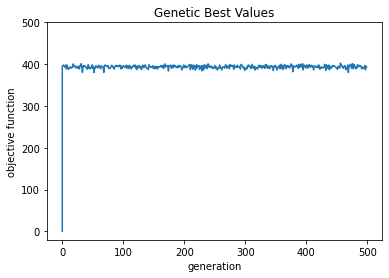

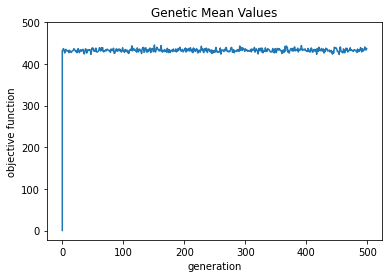

In [32]:
from numpy import matrix
from Patient import Patient
from Room import Room
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import time


######## READ DATA ###########
Patient_data = pd.read_csv('Patient10.csv')
Rooms_data = pd.read_csv('Rooms.csv')
random.seed(10)

######## Variables ##########
robot_speed = 6
cost = 200


def init_rooms(Rooms_data):
    room_dict = {}
    for room in Rooms_data.iterrows():
        room_dict[room[1]['id']] = Room(room[1]['id'], room[1]['x'], room[1]['y'])
    return room_dict


def init_patient(Patient_data, r_data):
    patient_array = []
    for patient in Patient_data.iterrows():
        patient_array.append(
            Patient(patient[1]['id'], r_data[patient[1]['room']], patient[1]['urgency'], patient[1]['typeofdisease']))
    return patient_array


def calc_dist(room1, room2):
    return (math.sqrt(((room1[0] - room2[0]) ** 2) + ((room1[1] - room2[1]) ** 2)))


def room_distance_matrix(room_data):
    df = pd.DataFrame(columns=range(1, len(room_data) + 1), index=range(1, len(room_data) + 1))
    for i in room_data.keys():
        for j in room_data.keys():
            df.at[i, j] = calc_dist(room_data[i].get_loc(), room_data[j].get_loc())
    return df


def patient_distance_matrix(patient_data):
    df = pd.DataFrame(columns=range(1, len(patient_data) + 1), index=range(1, len(patient_data) + 1))
    for i in range(1, len(patient_data) + 1):
        for j in range(1, len(patient_data) + 1):
            df.at[i, j] = calc_dist(patient_data[i - 1].room.get_loc(), patient_data[j - 1].room.get_loc())
    return df


def compute_patient_distance_coordinates(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

# objective functions
def objective_function(patient_a, patient_b, patients_dict,cost):
    target_value = 0
    distance = compute_patient_distance_coordinates(patients_dict[patient_a], patients_dict[patient_b])
    for pat in patient_data:
        if str(pat.id) == patient_a:
            time_of = (distance / robot_speed) + pat.type_of_disease
            latency = max(int(time_of - pat.urgency), 0)
            target_value = (time_of + latency * cost)

    return target_value


# First step: Create the first population set
def genesis(patient_list, n_population):
    population_set = []
    for i in range(n_population):
        # Randomly generating a new solution
        sol_i = patient_list[np.random.choice(list(range(n_patients)), n_patients, replace=False)]
        population_set.append(sol_i)
    return np.array(population_set)


# 2. Evaluation of the fitnesss

# individual solution
def fitnesss_eval(patient_list, patients_dict,cost):
    total = 0
    for i in range(n_patients - 1):
        a = patient_list[i]
        b = patient_list[i + 1]
        total += objective_function(a, b, patients_dict,cost)
    return total


# All solutions
def get_all_fitness(population_set, patients_dict,cost):
    fitness_list = np.zeros(n_population)

    # Looping over all solutions computing the fitness for each solution
    for i in range(n_population):
        fitness_list[i] = fitnesss_eval(population_set[i], patients_dict,cost)

    return fitness_list


# 3. Selecting the progenitors
def progenitor_selection(population_set, fitness_list):
    total_fit = fitness_list.sum()
    prob_list = fitness_list / total_fit

    # Notice there is the chance that a progenitor. mates with oneself
    progenitor_list_a = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list,
                                         replace=True)
    progenitor_list_b = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list,
                                         replace=True)

    progenitor_list_a = population_set[progenitor_list_a]
    progenitor_list_b = population_set[progenitor_list_b]

    return np.array([progenitor_list_a, progenitor_list_b])


# Pairs crossover
def mate_progenitors(prog_a, prog_b):
    offspring = prog_a[0:5]

    for patient in prog_b:

        if not patient in offspring:
            offspring = np.concatenate((offspring, [patient]))

    return offspring


# Finding pairs of mates
def mate_population(progenitor_list):
    new_population_set = []
    for i in range(progenitor_list.shape[1]):
        prog_a, prog_b = progenitor_list[0][i], progenitor_list[1][i]
        offspring = mate_progenitors(prog_a, prog_b)
        new_population_set.append(offspring)

    return new_population_set


# Offspring production
def mutate_offspring(offspring):
    for q in range(int(n_patients * mutation_rate)):
        a = np.random.randint(0, n_patients)
        b = np.random.randint(0, n_patients)

        offspring[a], offspring[b] = offspring[b], offspring[a]

    return offspring


# New populaiton generation
def mutate_population(new_population_set):
    mutated_pop = []
    for offspring in new_population_set:
        mutated_pop.append(mutate_offspring(offspring))
    return mutated_pop


if __name__ == '__main__':
#     for c in range(0,201,50):
#         print(c)
    room_data = init_rooms(Rooms_data)
    patient_data = init_patient(Patient_data, room_data)
    rooms_dist_matrix = room_distance_matrix(room_data)
    patients_dist_matrix = patient_distance_matrix(patient_data)
    fitness_list = patients_dist_matrix.values.tolist()[0]
    patient_coordinates_list = []
    names_list = []
    for i in patient_data:
        patient_coordinates_list.append([i.room.x, i.room.y])
    for i in patient_data:
        names_list.append(str(i.id))
    names_list = np.asarray(names_list)

    n_patients = 10
    n_population = 50
    mutation_rate = 0.1
    robot_speed = 6
    cost = 200
    generations = 500

    patients_dict = {x: y for x, y in zip(names_list, patient_coordinates_list)}
    population_set = genesis(names_list, n_population)
    fitness_list = get_all_fitness(population_set, patients_dict,cost)
    progenitor_list = progenitor_selection(population_set, fitness_list)
    new_population_set = mate_population(progenitor_list)
    mutated_pop = mutate_population(new_population_set)

    # Everything put together
    best_solution = [-1, np.inf, np.array([])]
    generations_list = [0]
    min_val_list = [0]
    mean_val_list = [0]
    start_time = time.time()

    for i in range(generations):

        # if i % 100 == 0: print(best_solution, fitness_list.min(), datetime.now().strftime("%d/%m/%y %H:%M"))
        fitness_list = get_all_fitness(mutated_pop, patients_dict,cost)
        # Saving the best solution
        if fitness_list.min() < best_solution[1]:
            best_solution[0] = i
            best_solution[1] = fitness_list.min()
            best_solution[2] = np.array(mutated_pop)[fitness_list.min() == fitness_list]
#                 print(best_solution, fitness_list.min())
        generations_list.append(i)
        min_val_list.append(fitness_list.min())
        mean_val_list.append(fitness_list.mean())
        progenitor_list = progenitor_selection(population_set, fitness_list)
        new_population_set = mate_population(progenitor_list)

        mutated_pop = mutate_population(new_population_set)
    print(best_solution, fitness_list.min())
#     print("for,",i," iterations, the time is: ",time.time() - start_time)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(generations_list, min_val_list)
plt.yticks( range(0,550,100) )
plt.title('Genetic Best Values')
plt.xlabel('generation')
plt.ylabel('objective function')

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(generations_list, mean_val_list)
plt.yticks( range(0,550,100) )
plt.title('Genetic Mean Values')
plt.xlabel('generation')
plt.ylabel('objective function')

In [ ]:
from numpy import matrix
from Patient import Patient
from Room import Room
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import time


######## READ DATA ###########
Patient_data = pd.read_csv('Patient10.csv')
Rooms_data = pd.read_csv('Rooms.csv')
random.seed(10)

######## Variables ##########
robot_speed = 6
cost = 200


def init_rooms(Rooms_data):
    room_dict = {}
    for room in Rooms_data.iterrows():
        room_dict[room[1]['id']] = Room(room[1]['id'], room[1]['x'], room[1]['y'])
    return room_dict


def init_patient(Patient_data, r_data):
    patient_array = []
    for patient in Patient_data.iterrows():
        patient_array.append(
            Patient(patient[1]['id'], r_data[patient[1]['room']], patient[1]['urgency'], patient[1]['typeofdisease']))
    return patient_array


def calc_dist(room1, room2):
    return (math.sqrt(((room1[0] - room2[0]) ** 2) + ((room1[1] - room2[1]) ** 2)))


def room_distance_matrix(room_data):
    df = pd.DataFrame(columns=range(1, len(room_data) + 1), index=range(1, len(room_data) + 1))
    for i in room_data.keys():
        for j in room_data.keys():
            df.at[i, j] = calc_dist(room_data[i].get_loc(), room_data[j].get_loc())
    return df


def patient_distance_matrix(patient_data):
    df = pd.DataFrame(columns=range(1, len(patient_data) + 1), index=range(1, len(patient_data) + 1))
    for i in range(1, len(patient_data) + 1):
        for j in range(1, len(patient_data) + 1):
            df.at[i, j] = calc_dist(patient_data[i - 1].room.get_loc(), patient_data[j - 1].room.get_loc())
    return df


def compute_patient_distance_coordinates(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

# objective functions
def objective_function(patient_a, patient_b, patients_dict,cost):
    target_value = 0
    distance = compute_patient_distance_coordinates(patients_dict[patient_a], patients_dict[patient_b])
    for pat in patient_data:
        if str(pat.id) == patient_a:
            time_of = (distance / robot_speed) + pat.type_of_disease
            latency = max(int(time_of - pat.urgency), 0)
            target_value = (time_of + latency * cost)

    return target_value


# First step: Create the first population set
def genesis(patient_list, n_population):
    population_set = []
    for i in range(n_population):
        # Randomly generating a new solution
        sol_i = patient_list[np.random.choice(list(range(n_patients)), n_patients, replace=False)]
        population_set.append(sol_i)
    return np.array(population_set)


# 2. Evaluation of the fitnesss

# individual solution
def fitnesss_eval(patient_list, patients_dict,cost):
    total = 0
    for i in range(n_patients - 1):
        a = patient_list[i]
        b = patient_list[i + 1]
        total += objective_function(a, b, patients_dict,cost)
    return total


# All solutions
def get_all_fitness(population_set, patients_dict,cost):
    fitness_list = np.zeros(n_population)

    # Looping over all solutions computing the fitness for each solution
    for i in range(n_population):
        fitness_list[i] = fitnesss_eval(population_set[i], patients_dict,cost)

    return fitness_list


# 3. Selecting the progenitors
def progenitor_selection(population_set, fitness_list):
    total_fit = fitness_list.sum()
    prob_list = fitness_list / total_fit

    # Notice there is the chance that a progenitor. mates with oneself
    progenitor_list_a = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list,
                                         replace=True)
    progenitor_list_b = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list,
                                         replace=True)

    progenitor_list_a = population_set[progenitor_list_a]
    progenitor_list_b = population_set[progenitor_list_b]

    return np.array([progenitor_list_a, progenitor_list_b])


# Pairs crossover
def mate_progenitors(prog_a, prog_b):
    offspring = prog_a[0:5]

    for patient in prog_b:

        if not patient in offspring:
            offspring = np.concatenate((offspring, [patient]))

    return offspring


# Finding pairs of mates
def mate_population(progenitor_list):
    new_population_set = []
    for i in range(progenitor_list.shape[1]):
        prog_a, prog_b = progenitor_list[0][i], progenitor_list[1][i]
        offspring = mate_progenitors(prog_a, prog_b)
        new_population_set.append(offspring)

    return new_population_set


# Offspring production
def mutate_offspring(offspring):
    for q in range(int(n_patients * mutation_rate)):
        a = np.random.randint(0, n_patients)
        b = np.random.randint(0, n_patients)

        offspring[a], offspring[b] = offspring[b], offspring[a]

    return offspring


# New populaiton generation
def mutate_population(new_population_set):
    mutated_pop = []
    for offspring in new_population_set:
        mutated_pop.append(mutate_offspring(offspring))
    return mutated_pop


if __name__ == '__main__':
#     for c in range(0,201,50):
#         print(c)
    room_data = init_rooms(Rooms_data)
    patient_data = init_patient(Patient_data, room_data)
    rooms_dist_matrix = room_distance_matrix(room_data)
    patients_dist_matrix = patient_distance_matrix(patient_data)
    fitness_list = patients_dist_matrix.values.tolist()[0]
    patient_coordinates_list = []
    names_list = []
    for i in patient_data:
        patient_coordinates_list.append([i.room.x, i.room.y])
    for i in patient_data:
        names_list.append(str(i.id))
    names_list = np.asarray(names_list)

    n_patients = 10
    n_population = 50
    mutation_rate = 0.1
    robot_speed = 6
    cost = 200
    generations = 500

    patients_dict = {x: y for x, y in zip(names_list, patient_coordinates_list)}
    population_set = genesis(names_list, n_population)
    fitness_list = get_all_fitness(population_set, patients_dict,cost)
    progenitor_list = progenitor_selection(population_set, fitness_list)
    new_population_set = mate_population(progenitor_list)
    mutated_pop = mutate_population(new_population_set)

    # Everything put together
    best_solution = [-1, np.inf, np.array([])]
    generations_list = [0]
    min_val_list = [0]
    mean_val_list = [0]
    start_time = time.time()

    for i in range(generations):

        # if i % 100 == 0: print(best_solution, fitness_list.min(), datetime.now().strftime("%d/%m/%y %H:%M"))
        fitness_list = get_all_fitness(mutated_pop, patients_dict,cost)
        # Saving the best solution
        if fitness_list.min() < best_solution[1]:
            best_solution[0] = i
            best_solution[1] = fitness_list.min()
            best_solution[2] = np.array(mutated_pop)[fitness_list.min() == fitness_list]
#                 print(best_solution, fitness_list.min())
        generations_list.append(i)
        min_val_list.append(fitness_list.min())
        mean_val_list.append(fitness_list.mean())
        progenitor_list = progenitor_selection(population_set, fitness_list)
        new_population_set = mate_population(progenitor_list)

        mutated_pop = mutate_population(new_population_set)
    print(best_solution, fitness_list.min())
#     print("for,",i," iterations, the time is: ",time.time() - start_time)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(generations_list, min_val_list)
plt.yticks( range(0,550,100) )
plt.title('Genetic Best Values')
plt.xlabel('generation')
plt.ylabel('objective function')

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(generations_list, mean_val_list)
plt.yticks( range(0,550,100) )
plt.title('Genetic Mean Values')
plt.xlabel('generation')
plt.ylabel('objective function')
